<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Introduction to CUDA Python with Numba

[Numba](http://numba.pydata.org/) is a just-in-time function compiler that exposes a simple interface that allows programmers to accelerate numerically-focused Python functions with very little code modification.

In this session you will learn first how to use Numba to compile functions for the CPU, and will receive an introduction to the inner workings of the Numba compiler. You will then proceed to learn how to accelerate numerically-focuses Python functions on massively parallel CUDA-enabled GPUs, along with some techniques for managing memory between a CPU host and GPU device. Throughout the session you will be executing and timing functions in order to observe the kinds of massive speedups made possible by GPU-accelerating Python functions with Numba.

## Prerequisites

* Familiarity coding in Python, specifically, writing and invoking functions, working with variables, loops, and conditionals.
* Familiarity with the Numpy Python library for numerically-focused Python. If you have never used Numpy, but are familiar with Python, you will likely find the use of Numpy in this session straightforward. Comments and links are provided where some clarification might be helpful.

## Objectives

By the time you complete this session you will be able to:

- Use Numba to compile Python functions for the CPU
- Understand how Numba compiles functions
- GPU accelerate NumPy ufuncs
- GPU accelerate hand-written vectorized functions
- Optimize memory transfers between the CPU host and GPU device

## What is Numba?

Numba is a **just-in-time**, **type-specializing**, **function compiler** for accelerating **numerically-focused** Python.  That's a long list, so let's break down those terms:

 * **function compiler**: Numba compiles Python functions, not entire applications, and not parts of functions.  Numba does not replace your Python interpreter, but is just another Python module that can turn a function into a (usually) faster function. 
 * **type-specializing**: Numba speeds up your function by generating a specialized implementation for the specific data types you are using.  Python functions are designed to operate on generic data types, which makes them very flexible, but also very slow.  In practice, you only will call a function with a small number of argument types, so Numba will generate a fast implementation for each set of types.
 * **just-in-time**: Numba translates functions when they are first called.  This ensures the compiler knows what argument types you will be using.  This also allows Numba to be used interactively in a Jupyter notebook just as easily as a traditional application
 * **numerically-focused**: Currently, Numba is focused on numerical data types, like `int`, `float`, and `complex`.  There is very limited string processing support, and many string use cases are not going to work well on the GPU.  To get best results with Numba, you will likely be using NumPy arrays.

## Requirements for Using Numba

Numba supports a wide range of operating systems:

 * Windows 7 and later, 32 and 64-bit
 * macOS 10.9 and later, 64-bit
 * Linux (most anything >= RHEL 5), 32-bit and 64-bit

and Python versions:

 * Python 2.7, 3.4-3.6
 * NumPy 1.10 and later

and a very wide range of hardware:

* x86, x86_64/AMD64 CPUs
* NVIDIA CUDA GPUs (Compute capability 3.0 and later, CUDA 8.0 and later)
* AMD GPUs (experimental patches)
* ARM (experimental patches)

For this tutorial, we will be using Linux 64-bit and CUDA 9.

## Installing Numba on Your Own System

You do not need to install Numba for this session, it has already been done, but after, when you would like to install it on your own system, installation is easy: please refer to [the docs](http://numba.pydata.org/numba-doc/latest/user/installing.html)

## First Steps: Compile for the CPU

As an introduction, let's write our first Numba function and compile it for the **CPU**. The Numba compiler is typically enabled by applying a [*function decorator*](https://en.wikipedia.org/wiki/Python_syntax_and_semantics#Decorators) to a Python function. Decorators are function modifiers that transform the Python functions they decorate, using a very simple syntax. Here we will use Numba's CPU compilation decorator `@jit`:

In [1]:
from numba import jit
import math

# This is the function decorator syntax and is equivalent to `hypot = jit(hypot)`.
# The Numba compiler is just a function you can call whenever you want!
@jit
def hypot(x, y):
    # Implementation from https://en.wikipedia.org/wiki/Hypot
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

Let's try out our hypotenuse calculation:

In [2]:
hypot(3.0, 4.0)

5.0

We will go in to more detail below about what happens when `hypot` is called, but for now know that the first time we call `hypot`, the compiler is triggered and compiles a machine code implementation for float inputs. Numba also saves the original Python implementation of the function in the `.py_func` attribute, so we can call the original Python code to make sure we get the same answer:

In [3]:
hypot.py_func(3.0, 4.0)

5.0

### Benchmarking

An important part of using Numba is measuring the performance of your new code.  Let's see if we actually sped anything up.  The easiest way to do this in a Jupyter notebook, like the one this session is run in, is to use the `%timeit` magic function.  Let's first measure the speed of the original Python:

In [4]:
%timeit hypot.py_func(3.0, 4.0)

The slowest run took 9.71 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 690 ns per loop


The `%timeit` magic runs the statement many times to get an accurate estimate of the run time.  It also returns the best time by default, which is useful to reduce the probability that random background events affect your measurement.  The best of 3 approach also ensures that the compilation time on the first call doesn't skew the results:

In [5]:
%timeit hypot(3.0, 4.0)

The slowest run took 21.65 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 194 ns per loop


Numba did a pretty good job with this function.  It's roughly 4x faster than the pure Python version.

Of course, the `hypot` function is already present in the Python module, let's see how it compares:

In [6]:
%timeit math.hypot(3.0, 4.0)

The slowest run took 44.67 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 130 ns per loop


Python's built-in is even faster than Numba! This is because Numba does introduce some overhead to each function call that is larger than the function call overhead of Python itself. Extremely fast functions (like the above one) will be hurt by this.

(However, if you call one Numba function from another one, there is very little function overhead, sometimes even zero if the compiler inlines the function into the other one. In short, always benchmark your functions for evidence of speed up.)

### Exercise: Use Numba to Compile a Function for the CPU

The following function uses [the Monte Carlo Method to determine Pi](https://academo.org/demos/estimating-pi-monte-carlo/) (source code from the [Numba homepage](http://numba.pydata.org/)). The function itself is already working so don't worry about the mathematical implementation details.

Complete the two `TODO`s in order to compile `monte_carlo_pi` with Numba before executing the following 3 cells which will:

  1. Confirm the compiled version is behaving the same as the uncompiled version.
  2. Benchmark the uncompiled version.
  3. Benchmark the compiled version.

If you get stuck, check out [the solution](../../../../edit/tasks/task1/task/solutions/monte_carlo_pi_solution.py).

In [7]:
nsamples = 1000000

In [8]:
from numba import jit # `jit` is the Numba just-in-time-compiler function
import random

@jit # Use the decorator syntax to mark `monte_carlo_pi` for Numba compilation
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [9]:
# We will use the `testing` library to confirm compiled and uncompiled versions run the same
from numpy import testing

# This assertion will fail until you successfully complete the exercise one cell above
testing.assert_almost_equal(monte_carlo_pi(nsamples), monte_carlo_pi.py_func(nsamples), decimal=2)

In [10]:
%timeit monte_carlo_pi(nsamples)

100 loops, best of 3: 11.5 ms per loop


In [11]:
%timeit monte_carlo_pi.py_func(nsamples)

1 loop, best of 3: 363 ms per loop


## How Numba Works

Now that you've gotton your hands a little dirty using the Numba compiler, let's take a look at what is actually going on under the hood. The first time we called our Numba-wrapped `hypot` function, the following process was initiated:

![Numba Flowchart](img/numba_flowchart.png "The compilation process")

We can see the result of type inference by using the `.inspect_types()` method, which prints an annotated version of the source code:

In [12]:
hypot.inspect_types()

hypot (float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-1-1ae6c289554e>
# --- LINE 6 --- 
# label 0
#   del x
#   del $0.1
#   del $0.3
#   del y
#   del $0.4
#   del $0.6
#   del $0.7
#   del $0.10
#   del y.1
#   del x.1
#   del $0.11
#   del $0.14
#   del t
#   del $0.17
#   del $0.19
#   del t.1
#   del $const0.21
#   del $0.24
#   del $0.25
#   del $0.20
#   del x.2
#   del $0.26
#   del $0.27

@jit

# --- LINE 7 --- 

def hypot(x, y):

    # --- LINE 8 --- 

    # Implementation from https://en.wikipedia.org/wiki/Hypot

    # --- LINE 9 --- 
    #   x = arg(0, name=x)  :: float64
    #   y = arg(1, name=y)  :: float64
    #   $0.1 = global(abs: <built-in function abs>)  :: Function(<built-in function abs>)
    #   $0.3 = call $0.1(x, func=$0.1, args=[Var(x, <ipython-input-1-1ae6c289554e> (9))], kws=(), vararg=None)  :: (float64,) -> float64
    #   x.1 = $0.3  :: float64

    x = abs(x);

    # --- LINE 10 -

Note that Numba's type names tend to mirror [the NumPy type names](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html), so a Python `float` is a `float64` (also called "double precision" in other languages).  Taking a look at the data types can sometimes be important in GPU code because the performance of `float32` and `float64` computations will be very different on CUDA devices.  An accidental upcast can dramatically slow down a function.

## Object and nopython Modes

Numba cannot compile all Python code.  Some functions don't have a Numba-translation, and some kinds of Python types can't be efficiently compiled at all (yet).  For example, Numba does not support dictionaries (as of this tutorial). Here let's try to compile some Python code that Numba does not yet know how to compile:

In [13]:
@jit
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

'value'

Given what we just said, you might be surpised that the cell above executed without any problems. This is because by default, Numba will fall back to a mode, called "object mode," which does not do type-specialization. Object mode exists to enable other Numba functionality, but in many cases, you want Numba to tell you if type inference fails. You can force "nopython mode" (the other compilation mode) by passing the `nopython` argument to the decorator:

In [14]:
@jit(nopython=True)
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

TypingError: Failed at nopython (nopython frontend)
Internal error at <numba.typeinfer.ArgConstraint object at 0x7f5b381d1710>:
--%<-----------------------------------------------------------------
Traceback (most recent call last):
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 259, in new_error_context
    yield
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 189, in __call__
    assert ty.is_precise()
AssertionError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 137, in propagate
    constraint(typeinfer)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 190, in __call__
    typeinfer.add_type(self.dst, ty, loc=self.loc)
  File "/home/appuser/Miniconda3/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 265, in new_error_context
    six.reraise(type(newerr), newerr, sys.exc_info()[2])
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/six.py", line 658, in reraise
    raise value.with_traceback(tb)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 259, in new_error_context
    yield
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 189, in __call__
    assert ty.is_precise()
numba.errors.InternalError: 
[1] During: typing of argument at <ipython-input-14-d3b98ca43e8a> (3)
--%<-----------------------------------------------------------------

File "<ipython-input-14-d3b98ca43e8a>", line 3

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'dict'>


Now we get an exception when Numba tries to compile the function, and if you scroll down to the end of the exception output you will see an error that describes the underlying problem:
```
- argument 0: cannot determine Numba type of <class 'dict'>
```

Numba provides another decorator `njit` which is an alias for `jit(nopython=True)`:

In [15]:
from numba import njit

@njit
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

TypingError: Failed at nopython (nopython frontend)
Internal error at <numba.typeinfer.ArgConstraint object at 0x7f5b3810c860>:
--%<-----------------------------------------------------------------
Traceback (most recent call last):
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 259, in new_error_context
    yield
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 189, in __call__
    assert ty.is_precise()
AssertionError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 137, in propagate
    constraint(typeinfer)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 190, in __call__
    typeinfer.add_type(self.dst, ty, loc=self.loc)
  File "/home/appuser/Miniconda3/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 265, in new_error_context
    six.reraise(type(newerr), newerr, sys.exc_info()[2])
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/six.py", line 658, in reraise
    raise value.with_traceback(tb)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 259, in new_error_context
    yield
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 189, in __call__
    assert ty.is_precise()
numba.errors.InternalError: 
[1] During: typing of argument at <ipython-input-15-598d254e6e01> (5)
--%<-----------------------------------------------------------------

File "<ipython-input-15-598d254e6e01>", line 5

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'dict'>


Please refer to [the Numba documentation](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html) for an exhaustive account of Numba-supported Python.

## Introduction to Numba for the GPU

There are two basic approaches to GPU programming in Numba:

 1. ufuncs/gufuncs
 2. CUDA Python kernels
 
In this (2 hour) session we will cover ufuncs, before then moving on to some memory optimization techniques. If you're interested to learn custom Python CUDA kernels and/or gufuncs, please consider the longer, full-day DLI course [The Fundamentals of Accelerated Computing with CUDA Python](https://courses.nvidia.com/courses/course-v1:DLI+C-AC-02+V1/about) 

The most important thing to know at the present about GPU programming is that the hardware is designed for *data parallelism*. Maximum throughput is achieved when you are computing the same operations on many different elements at once.

NumPy universal functions are naturally data parallel, so we will begin with them.

## Numpy Universal Functions (ufuncs)

NumPy has the concept of universal functions ("ufuncs"), which are functions that can take NumPy arrays of varying dimensions, or scalars, and operate on them element-by-element.

In case you aren't familiar with ufuncs, here is an example. We'll use the NumPy `add` ufunc to demonstrate what happens:

In [16]:
import numpy as np

a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

np.add(a, b)

array([11, 22, 33, 44])

Ufuncs also can combine scalars with arrays:

In [17]:
np.add(a, 100)

array([101, 102, 103, 104])

Arrays of different, but compatible dimensions can also be combined. The lower dimensional array will be replicated to match the dimensionality of the higher dimensional array. If needed, check out the docs for [`numpy.arange`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.arange.html) and [`numpy.ndarray.reshape`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.reshape.html):

In [18]:
c = np.arange(4*4).reshape((4,4))
print('c:', c)

np.add(b, c)

c: [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]])

In the above situation, the `b` array is added to each row of `c`.  If we want to add `b` to each column, we need to transpose it.  There are several ways to do this, but one way is to insert a new axis using [`np.newaxis`](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#numpy.newaxis):

In [19]:
b_col = b[:, np.newaxis]
b_col

array([[10],
       [20],
       [30],
       [40]])

In [20]:
np.add(b_col, c)

array([[10, 11, 12, 13],
       [24, 25, 26, 27],
       [38, 39, 40, 41],
       [52, 53, 54, 55]])

The NumPy documentation has a [much more extensive discussion of ufuncs](https://docs.scipy.org/doc/numpy/reference/ufuncs.html):

## Making ufuncs for the GPU

Numba has the ability to create compiled ufuncs.  You implement a scalar function of all the inputs, and Numba will figure out the broadcast rules for you. Generating a ufunc that uses CUDA requires giving an explicit type signature and setting the `target` attribute:

In [21]:
from numba import vectorize

@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [22]:
print('a+b:\n', add_ufunc(a, b))
print()
print('b_col + c:\n', add_ufunc(b_col, c))

a+b:
 [11 22 33 44]

b_col + c:
 [[10 11 12 13]
 [24 25 26 27]
 [38 39 40 41]
 [52 53 54 55]]


A lot of things just happened!  Numba automatically:

 * Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
 * Allocated GPU memory for the inputs and the output.
 * Copied the input data to the GPU.
 * Executed the CUDA kernel with the correct kernel dimensions given the input sizes.
 * Copied the result back from the GPU to the CPU.
 * Returned the result as a NumPy array on the host.

Returning results back to the host for `print` statments is very convenient for testing, but copying data back and forth between the CPU and GPU can be slow and hurt performance. Later is this session, you'll learn about device management and memory allocation.

You might be wondering how fast our simple example is on the GPU?  Let's see:

In [23]:
%timeit np.add(b_col, c)   # NumPy on CPU

The slowest run took 19.71 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.11 µs per loop


In [24]:
%timeit add_ufunc(b_col, c) # Numba on GPU

1000 loops, best of 3: 782 µs per loop


Wow, the GPU is *a lot slower* than the CPU??  This is to be expected because we have (deliberately) misused the GPU in several ways in this example:

  * **Our inputs are too small**: the GPU achieves performance through parallelism, operating on thousands of values at once.  Our test inputs have only 4 and 16 integers, respectively.  We need a much larger array to even keep the GPU busy.
  * **Our calculation is too simple**: Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU.  If our calculation does not involve enough math operations (often called "arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
  * **We copy the data to and from the GPU**: While including the copy time can be realistic for a single function, often we want to run several GPU operations in sequence.  In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
  * **Our data types are larger than necessary**: Our example uses `int64` when we probably don't need it.  Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, but 64-bit data types have a significant performance cost on the GPU.  Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats.  NumPy defaults to 64-bit data types when creating arrays, so it is important to set the `dtype` attribute or use the `ndarray.astype()` method to pick 32-bit types when you need them.
  
  
Given the above, let's try an example that is faster on the GPU:

In [25]:
import math  # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [29]:
# Evaluate the Gaussian a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test, evaluate the Gaussian PDF
gaussian_pdf(x[0], 0.0, 1.0)

array([0.00619957], dtype=float32)

In [30]:
import scipy.stats # for definition of gaussian distribution
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

10 loops, best of 3: 57.4 ms per loop


In [31]:
%timeit gaussian_pdf(x, mean, sigma)

100 loops, best of 3: 3.68 ms per loop


That's a pretty large improvement, even including the overhead of copying all the data to and from the GPU.  Ufuncs that use special functions (`exp`, `sin`, `cos`, etc) on large data sets run especially well on the GPU.

## CUDA Device Functions

Ufuncs are great, but you should not have to cram all of your logic into a single function body. You can also create normal functions that are only called from other functions running on the GPU. (For those of you familiar with CUDA C, these are similar to CUDA C functions defined with `__device__`.)

Device functions are created with the `numba.cuda.jit` decorator:

In [33]:
from numba import cuda

@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y  # This is Python, so let's return a tuple

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [34]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [35]:
polar_distance(rho1, theta1, rho2, theta2)

array([1.9941373 , 2.548199  , 2.692227  , ..., 2.617274  , 0.38231683,
       1.8564444 ], dtype=float32)

Note that the CUDA compiler aggressively inlines device functions, so there is generally no overhead for function calls.  Similarly, the "tuple" returned by `polar_to_cartesian` is not actually created as a Python object, but represented temporarily as a struct, which is then optimized away by the compiler.

## Allowed Python on the GPU

Compared to Numba on the CPU (which is already limited), Numba on the GPU has more limitations.  Supported Python includes:

* `if`/`elif`/`else`
* `while` and `for` loops
* Basic math operators
* Selected functions from the `math` and `cmath` modules
* Tuples

See [the Numba manual](http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html) for more details.

## Exercise: GPU Accelerate a Function

Let's GPU accelerate a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. Let's make some sample data:

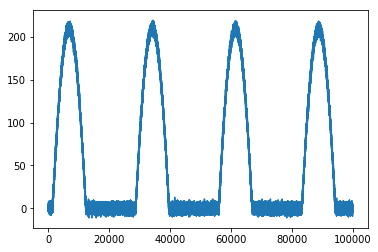

In [36]:
# Hacking up a noisy pulse train
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

Now decorate this `zero_suppress` function to run as a vectorized function on the CUDA device. Check out [the solution](../../../../edit/tasks/task1/task/solutions/zero_suppress_solution.py) if you get stuck.

In [48]:
@vectorize(['int16(int16, float32)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    if waveform_value < threshold:
        result = 0
    else:
        result = waveform_value
    return result

# @vectorize(['float32(float32, float32)'], target='cuda')
# TypeError: No matching version. GPU ufunc requires array arguments to have the exact types. 
# This behaves like regular ufunc with casting='no'.

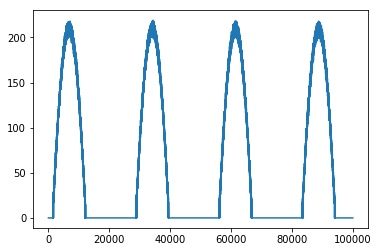

In [49]:
# This will throw an error until you successfully vectorize the `zero_suppress` function above.
# The noise on the baseline should disappear when zero_suppress is implemented
plt.plot(zero_suppress(waveform, 15.0))

## Managing GPU Memory

During the benchmarking in the previous notebook, we used NumPy arrays on the CPU as inputs and outputs.  If you want to reduce the impact of host-to-device/device-to-host bandwidth, it is best to copy data to the GPU explicitly and leave it there to amortize the cost over multiple function calls.  In addition, allocating device memory can be relatively slow, so allocating GPU arrays once and refilling them with data from the host can also be a performance improvement.

Let's create our example addition ufunc again:

In [78]:
from numba import vectorize
import numpy as np

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [79]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [52]:
%timeit add_ufunc(x, y)  # Baseline performance with host arrays

The slowest run took 112.89 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.02 ms per loop


The `numba.cuda` module includes a function that will copy host data to the GPU and return a CUDA device array:

In [53]:
from numba import cuda

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


Device arrays can be passed to CUDA functions just like NumPy arrays, but without the copy overhead:

In [54]:
%timeit add_ufunc(x_device, y_device)

1000 loops, best of 3: 448 µs per loop


That's a big performance improvement already, but we are still allocating a device array for the output of the ufunc and copying it back to the host.  We can create the output buffer with the `numba.cuda.device_array()` function:

In [55]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

And then we can use a special `out` keyword argument to the ufunc to specify the output buffer:

In [56]:
%timeit add_ufunc(x_device, y_device, out=out_device)

1000 loops, best of 3: 274 µs per loop


Now that we have removed the device allocation and copy steps, the computation runs *much* faster than before.  When we want to bring the device array back to the host memory, we can use the `copy_to_host()` method:

In [57]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


## Exercise: Optimize Memory Movement

Given these ufuncs:

In [80]:
import math

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

Convert this code to use device allocations so that there are only host<->device copies at the beginning and end and benchmark performance change:

In [81]:
d_noise = cuda.to_device(noise)
d_t = cuda.to_device(t)
d_pulses = cuda.device_array(shape=(n,), dtype=np.float32)
d_waveform = cuda.device_array(shape=(n,), dtype=np.float32)

make_pulses(d_t, period, 100.0, out=d_pulses)
add_ufunc(d_pulses, d_noise, out=d_waveform)
waveform = d_waveform.copy_to_host()

# pulses = make_pulses(t, period, 100.0)
# waveform = add_ufunc(pulses, noise)

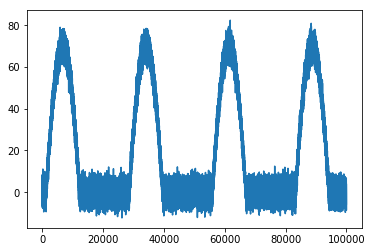

In [82]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

## Summary

Now that you have completed this session you are able to:

- Use Numba to compile Python functions for the CPU
- Understand how Numba compiles functions
- GPU accelerate NumPy ufuncs
- GPU accelerate hand-written vectorized functions
- Optimize memory transfers between the CPU host and GPU device

<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>